In [306]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [307]:
import tensorflow as tf
print(tf.__version__)

2.2.0


# Fetch mpg dataset
Download from UCI Archive then import using pandas#read_csv

In [308]:
dataset_path = tf.keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dataset_path

'/Users/theodoretan/.keras/datasets/auto-mpg.data'

In [309]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

# multi-space delimited data file with model+make at end after a tab
raw_dataset = pd.read_csv(dataset_path, names=column_names, sep=' ', skipinitialspace=True, comment='\t', na_values='?')
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


# Data cleaning

Drop rows with unknown/missing values. Another way to handle missing values is imputation.

In [310]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [311]:
dataset = dataset.dropna()
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Convert categorical `'Origin'` column to a one-hot (column per category, with a 1 value if row is part of that category)

In [312]:
dataset.Origin = dataset.Origin.map({ 1: 'USA', 2: 'EUR', 3: "JPN" })
dataset = pd.get_dummies(dataset, columns=['Origin'])
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_EUR,Origin_JPN,Origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


# Split training and testing data

In [313]:
# 80/20 split, random_state is any seed number but ensures reproducibility
training_data = dataset.sample(frac=0.8, random_state=0)
test_data = dataset.drop(training_data.index)
print('# training data points:', len(training_data.index), '\n# test data points:', len(test_data.index))

# training data points: 314 
# test data points: 78


Visualizing distribution of MPG vs Cylinders vs Horsepower vs Weight - `'kde'` is kernal density estimates type.

We can see a clear negative correlation between weight-mpg and horsepower-mpg


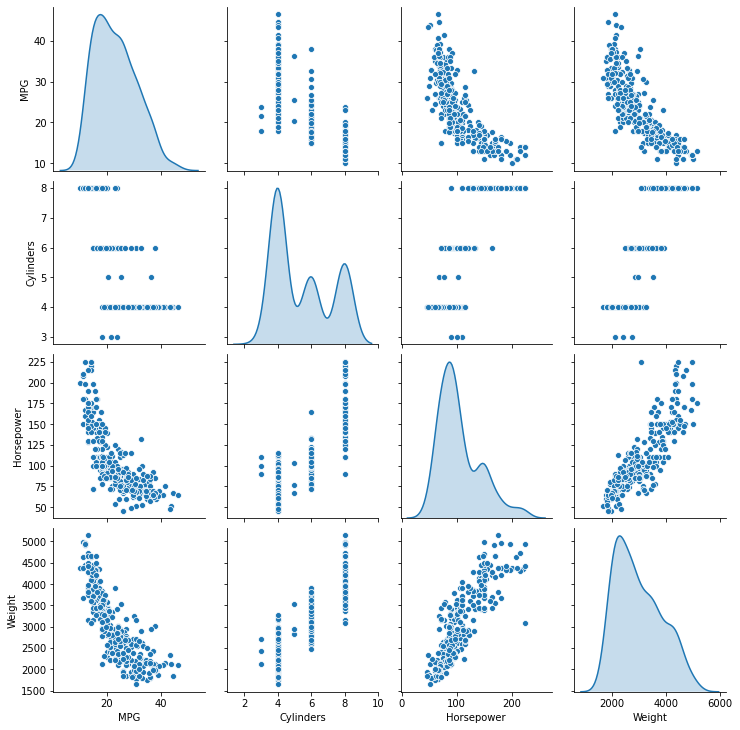

In [314]:
sns.pairplot(training_data[['MPG', 'Cylinders', 'Horsepower', 'Weight']], diag_kind='kde')

# Split features from labels (target values, MPG)

In [315]:
training_labels = training_data.pop('MPG')
test_labels = test_data.pop('MPG')

In [316]:
training_labels # should just be a one column series of MPG

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [317]:
training_stats = training_data.describe()
training_stats = training_stats.transpose() # pivot columns to rows
training_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin_EUR,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Origin_JPN,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
Origin_USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


Examining the overall statistics of the training dataset

# Normalize data
The range of each feature is very different e.g. 3-8 cylinders vs 1649-5140 weight. The model can still converge but training and result become dependent on unit. Normalization allows any unit to be used as long as they are on the same scale. We can easily normalize by subtracting each value by the mean and dividing by the standard deviation.

On ANY input data we must apply the one-hot encoding and normalize in the same way so the prediction remains accurate.

In [318]:
def normalize(data):
    return (data - training_stats['mean']) / training_stats['std']

normalized_training_data = normalize(training_data)
normalized_test_data = normalize(test_data)
normalized_training_data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,1.824443e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,8.627211e-17,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-9.900078e-18,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-8.485781e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,-5.148041e-16,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.772791e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
Origin_EUR,314.0,1.980016e-17,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Origin_JPN,314.0,5.374328e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852
Origin_USA,314.0,7.920062e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676


# Modeling (finally)

Building the model with `keras.Sequential` and two `Dense` hidden layers. The output layer returns a single continuous value.

RMSprop (root mean square prop) is used as an optimizing function, which uses a moving average of squared gradients to normalize the gradient itself.
The optimizing function is a way to find the parameters which minimize the loss function.

In [319]:
# reset the tensorflow graph
tf.keras.backend.clear_session()

In [320]:
def build_model(data, learning_rate):
    model = tf.keras.Sequential()
    # activation ReLU is a function which decides whether a neuron should be acitvated.
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[len(data.keys())])) # model takes as input arays of shape (*, len(keys)), output array of shape (*, 64)
    model.add(tf.keras.layers.Dense(64, activation='relu')) # don't need to specify input size after first layer p.s. this is the "hidden" layer
    model.add(tf.keras.layers.Dense(1)) # final output layer is a single continuous value


    optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    # use mean squared error as loss function which tells us how good our current model is
    # ELU(alpha=1.0) is best, LeakyReLU(alpha=0.01), RReLU if your network is overfitting, or PReLU if you have a huge training set.
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse']) # see if maybe MAE is a better loss function
    
    return model

In [321]:
LEARNING_RATE = 0.001 # size of step to descend. if error oscillates, reduce. if error is consistent but slow, increase.
model = build_model(normalized_training_data, LEARNING_RATE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Test model fit on some training data to verify shape (the answer will be completely wrong since the model is not yet trained)

In [322]:
training_batch = normalized_training_data[:10]
training_result = model.predict(training_batch)
training_result

array([[ 0.0630963 ],
       [ 0.01688681],
       [ 0.10007808],
       [-0.11237693],
       [ 0.06213222],
       [ 0.03343529],
       [ 0.06046722],
       [ 0.03689913],
       [-0.03657769],
       [-0.18175216]], dtype=float32)

## Train the model

In [323]:
EPOCHS = 500
class EpochDots(tf.keras.callbacks.Callback):
  """A simple callback that prints a "." every epoch, with occasional reports.
  Args:
    report_every: How many epochs between full reports
    dot_every: How many epochs between dots.
  """

  def __init__(self, report_every=100, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every

  def on_epoch_end(self, epoch, logs):
    if epoch % self.report_every == 0:
      print()
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=',  ')
      print()

    if epoch % self.dot_every == 0:
      print('.', end='')

history = model.fit(normalized_training_data, training_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[EpochDots()])


Epoch: 0, loss:570.8207,  mae:22.5904,  mse:570.8207,  val_loss:565.1907,  val_mae:22.4030,  val_mse:565.1907,  
....................................................................................................
Epoch: 100, loss:6.0652,  mae:1.7567,  mse:6.0652,  val_loss:8.9960,  val_mae:2.3352,  val_mse:8.9960,  
....................................................................................................
Epoch: 200, loss:5.4878,  mae:1.6330,  mse:5.4878,  val_loss:9.2833,  val_mae:2.3303,  val_mse:9.2833,  
....................................................................................................
Epoch: 300, loss:4.9207,  mae:1.5266,  mse:4.9207,  val_loss:9.2533,  val_mae:2.3651,  val_mse:9.2533,  
....................................................................................................
Epoch: 400, loss:4.5223,  mae:1.4651,  mse:4.5223,  val_loss:9.5233,  val_mae:2.3410,  val_mse:9.5233,  
..............................................................

In [324]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,570.820679,22.590391,570.820679,565.190674,22.403036,565.190674,0
1,523.296082,21.486538,523.296082,517.237183,21.245237,517.237183,1
2,477.487610,20.351435,477.487610,466.676697,19.974556,466.676697,2
3,428.360107,19.071363,428.360107,411.127472,18.494406,411.127472,3
4,375.469604,17.601963,375.469604,353.923981,16.849939,353.923981,4
...,...,...,...,...,...,...,...
495,4.207253,1.404496,4.207253,10.025537,2.441118,10.025537,495
496,4.172149,1.370519,4.172149,9.724468,2.377875,9.724468,496
497,4.144830,1.399391,4.144830,10.080516,2.334370,10.080516,497
498,4.094393,1.372313,4.094393,9.814576,2.349117,9.814576,498


In [325]:
prop_cycle = plt.rcParams['axes.prop_cycle']
COLOR_CYCLE = prop_cycle.by_key()['color']
def _smooth(values, std):
  """Smooths a list of values by convolving with a gussian.
  Assumes equal spacing.
  Args:
    values: A 1D array of values to smooth.
    std: The standard devistion of the gussian. The units are array elements.
  Returns:
    The smoothed array.
  """
  width = std * 4
  x = np.linspace(-width, width, 2 * width + 1)
  kernel = np.exp(-(x / 5)**2)

  values = np.array(values)
  weights = np.ones_like(values)

  smoothed_values = np.convolve(values, kernel, mode='same')
  smoothed_weights = np.convolve(weights, kernel, mode='same')

  return smoothed_values / smoothed_weights
  
class HistoryPlotter(object):
  """A class for plotting named set of keras-histories.
  The class maintains colors for each key from plot to plot.
  """

  def __init__(self, metric=None, smoothing_std=None):
    self.color_table = {}
    self.metric = metric
    self.smoothing_std = smoothing_std

  def plot(self, histories, metric=None, smoothing_std=None):
    """Plots a {name: history} dictionary of keras histories.
    Colors are assigned to the name-key, and maintained from call to call.
    Training metrics are shown as a solid line, validation metrics dashed.
    Args:
      histories: {name: history} dictionary of keras histories.
      metric: which metric to plot from all the histories.
      smoothing_std: the standard-deviaation of the smoothing kernel applied
        before plotting. The units are in array-indices.
    """
    if metric is None:
      metric = self.metric
    if smoothing_std is None:
      smoothing_std = self.smoothing_std

    for name, history in histories.items():
      # Remember name->color asociations.
      if name in self.color_table:
        color = self.color_table[name]
      else:
        color = COLOR_CYCLE[len(self.color_table) % len(COLOR_CYCLE)]
        self.color_table[name] = color

      train_value = history.history[metric]
      val_value = history.history['val_' + metric]
      if smoothing_std is not None:
        train_value = _smooth(train_value, std=smoothing_std)
        val_value = _smooth(val_value, std=smoothing_std)

      plt.plot(
          history.epoch,
          train_value,
          color=color,
          label=name.title() + ' Train')
      plt.plot(
          history.epoch,
          val_value,
          '--',
          label=name.title() + ' Val',
          color=color)

    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()

    plt.xlim(
        [0, max([history.epoch[-1] for name, history in histories.items()])])
    plt.grid(True)

Text(0, 0.5, 'MAE [MPG], MSE [MPG^2]')

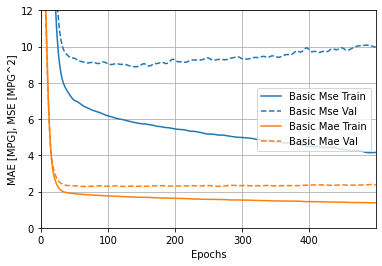

In [326]:
plotter = HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic MSE': history}, metric='mse')
plotter.plot({'Basic MAE': history}, metric='mae')

plt.ylim([0, 12])
plt.ylabel('MAE [MPG], MSE [MPG^2]')

Above history plot shows degradation in val error after about 100 epochs (train diverges from val). We need to update `model.fit` to stop training when validation score does not improve.

`tf.keras.callbacks.EarlyStopping` is a training condition function which tests if after a set amount of epochs there is no improvement, then stop training

In [327]:
model = build_model(normalized_training_data, LEARNING_RATE)

# patience is num epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# try to fit model again
early_history = model.fit(normalized_training_data, training_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, EpochDots()])


Epoch: 0, loss:549.1754,  mae:22.1047,  mse:549.1754,  val_loss:534.0479,  val_mae:21.7393,  val_mse:534.0479,  
.............................................

In [328]:
history_df = pd.DataFrame(early_history.history)
history_df['epoch'] = early_history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,549.175354,22.104691,549.175354,534.047913,21.739336,534.047913,0
1,487.712708,20.742027,487.712708,467.325012,20.209194,467.325012,1
2,424.122833,19.219337,424.122833,397.693451,18.464361,397.693451,2
3,358.004791,17.462904,358.004791,326.994415,16.491331,326.994415,3
4,289.885986,15.498615,289.885986,255.218979,14.353559,255.218979,4
5,223.166672,13.397149,223.166672,187.960999,12.160445,187.960999,5
6,161.490692,11.297530,161.490692,128.088440,10.008076,128.088440,6
7,108.893982,9.121764,108.893982,81.300888,7.942993,81.300888,7
8,68.757050,7.073203,68.757050,48.741566,6.156250,48.741566,8
9,43.380417,5.312247,43.380417,31.990126,4.943722,31.990126,9


Text(0, 0.5, 'MAE [MPG], MSE [MPG^2]')

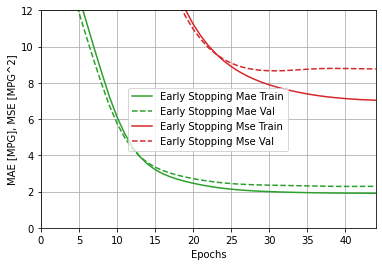

In [329]:
plotter.plot({'Early Stopping MAE': early_history}, metric = "mae")
plotter.plot({'Early Stopping MSE': early_history}, metric = "mse")
plt.ylim([0, 12])
plt.ylabel('MAE [MPG], MSE [MPG^2]')

Above graph shows MSE improves for early stopping method. MAE shows that the average error of our prediction will be +/- 2 MPG.

In [330]:
loss, mae, mse = model.evaluate(normalized_test_data, test_labels, batch_size=1, verbose=1)
print("Testing set Mean Absolute Error: {:5.2f} MPG".format(mae))

78/78 [==============================] - 0s 823us/step - loss: 5.7078 - mae: 1.8880 - mse: 5.7078
Testing set Mean Absolute Error:  1.89 MPG


# Making predictions with our trained model!

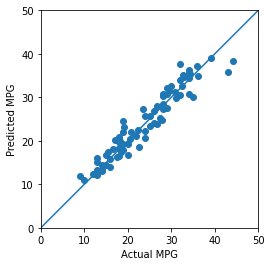

In [331]:
test_predictions = model.predict(normalized_test_data).flatten()
ax = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Error distribution examination

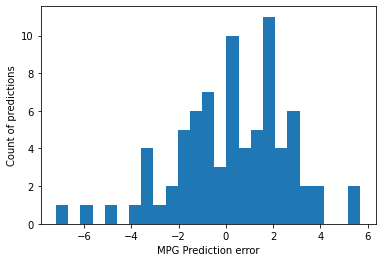

In [332]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('MPG Prediction error')
plt.ylabel('Count of predictions')
_ = plt.plot()